In [16]:
import tensorflow as tf
import numpy as np
import pandas as pd
import copy
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost
import pickle

In [2]:
columns=['building','barren_land','trees','grassland','road','water']

x_train = pd.read_csv(tf.gfile.Open('data/X_train_sat6.csv'),header=None)
y_train = pd.read_csv(tf.gfile.Open('data/y_train_sat6.csv'),header=None)
# reshape for cnn
x_train_cnn = x_train.values.reshape(x_train.shape[0],28,28,4)#.astype(np.float32)

x_test = pd.read_csv(tf.gfile.Open('data/X_test_sat6.csv'),header=None)
y_test = pd.read_csv(tf.gfile.Open('data/y_test_sat6.csv'),header=None)
# reshape for cnn
x_test_cnn = x_test.values.reshape(x_test.shape[0],28,28,4)#.astype(np.float32)

print("All files loaded")

All files loaded


In [3]:
def return_class_weights():
    y_ints = [y.argmax() for y in y_train.values]
    class_weights = class_weight.compute_class_weight('balanced',
                                                     np.unique(y_ints),
                                                     y_ints)
    return class_weights

In [34]:
def train_random_forest(model_title, x_train, y_train):
    model = RandomForestClassifier(n_estimators=50, n_jobs=-1)
    model.fit(x_train.values ,y_train.values)
    
    #save model
    pickle_model(model,model_title)
    
    return model

In [4]:
def train_cnn(x_train_cnn, y_train, version_num, lr=5.5e-5, optimizer='atom'):

    model = tf.keras.Sequential()

    # 1 convolutional layer - 32 filters, 5x5 kernel_size, padding=same, activation=relu
    model.add(tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu', input_shape=(28, 28, 4)))

    # 2 maxpool layer - pool_size=2x2, strides=2
    model.add(tf.keras.layers.MaxPooling2D(strides=2))

    # 3 convolutional layer - 64 filters, 5x5 kernel_size, padding=same, activation=relu
    model.add(tf.keras.layers.Conv2D(64, (5,5), padding='same', activation='relu'))

    # 4 maxpool layer - pool_size=2x2, strides=2
    model.add(tf.keras.layers.MaxPooling2D(strides=2))

    # 5 flatten layer 4 output
    model.add(tf.keras.layers.Flatten())

    # 6 fully connected layer - 1024 units, relu activation
    model.add(tf.keras.layers.Dense(1024, activation='relu'))

    # 7 dropout layer
    model.add(tf.keras.layers.Dropout(rate=0.5))

    # 8 fully connected layer - 256 units, relu activation
    model.add(tf.keras.layers.Dense(256, activation='relu'))

    # 9 fully connected layer - 6 units, (softmax activation)
    model.add(tf.keras.layers.Dense(6, activation='softmax'))

    # configure optimizer
    if optimizer == 'atom':
        
        atom = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=False)
        
    elif optimizer == 'sgd':
        
        sgd = tf.keras.optimizers.SGD(lr, momentum=0.9, nesterov=True)

    # compile model
    model.compile(loss='categorical_crossentropy', optimizer=atom, metrics=['accuracy'])
    
    # fit model
    model.fit(x_train_cnn, y_train, batch_size=32, epochs=10)
    
    # save model
    title = 'baseline_model_'+optimizer+'_'+str(lr)+'_v'
    model.save(title+str(version_num)+'.h5')
    
    return model

In [5]:
def load_cnn(filename):
    """Returns model object"""
    return tf.keras.models.load_model(filename)

In [6]:
def evaluate_cnn(model, title):
    # evaluate model
    score = model.evaluate(x_test_cnn, y_test, batch_size=32)
    print("Model accuracy = "+str(score[1]))
    
    actuals = y_test.idxmax(axis=1)
    cnn_preds = pd.DataFrame(model.predict(x_test_cnn)).idxmax(axis=1)
    
    gen_confusion(cnn_preds, actuals, title)

In [45]:
def gen_confusion(predictions, actuals, sub_title):
    
    # Measure accuracy
    accuracy = (predictions==actuals).sum()/(actuals.size)
    accuracy_str = " - Accuracy = %.5f" % accuracy
    
    
    title = sub_title+accuracy_str
    
    # Generate confusion matrix
    fig, ax = plt.subplots(figsize=(15, 12))
    Z = confusion_matrix(actuals, predictions)
    
    # Normalize across predictions (not linalg l2 normalization)
    norm_Z = np.divide(Z, np.sum(Z, axis=1))
    
#     # Linalg normalize across predictions
#     norm_Z = normalize(Z, axis=1)

    # Generate heatmap
    sns.heatmap(norm_Z, cmap=plt.cm.nipy_spectral, annot=True, cbar=True, xticklabels=columns, yticklabels=columns)

    ## Format axes object
    ax.xaxis.set_ticks_position('top') 
    ax.xaxis.set_label_position('top')
    #  Format X-axis label and ticks
    plt.xticks(fontsize=12)
    plt.xlabel('Predicted', fontdict={'size': 18})

    # Format Y-axis label
    plt.yticks(rotation=0, fontsize=12)
    plt.ylabel('Actual', rotation=0, fontdict={'size': 18})
    
    
    ax.set_title(f'6 Landcover Classes – {title}\n\n\n', fontdict={'size': 18, 'weight': 'bold'});
    subtitle = sub_title.replace(" ", "_")
    accuracy_str = "_Accuracy_%.5f" % accuracy
    title = subtitle+accuracy_str
    fig.savefig(f'Six_Landcover_Classes_{title}.png', bbox_inches='tight', dpi=300)

In [8]:
def get_feature_layer(model, data):
    
    if model==None:
        # load trained cnn
        model = load_cnn("baseline_model_atom_5.5e-5.h5")
    
    total_layers = len(model.layers)
    
    fl_index = total_layers-1
    
    feature_layer_model = tf.keras.Model(inputs=model.input,
                                outputs=model.get_layer(index=fl_index).output)
    
    feature_layer_output = feature_layer_model.predict(data)
    
    return feature_layer_output

In [9]:
def train_xgboost_cnn(x_train_cnn, y_train, version, num_features=None, cnn_model=None, num_round=100, gpu=False):
        
    # get feature layer train data
    if not num_features:
        feat_out = get_feature_layer(cnn_model, x_train_cnn)
    else:
        feat_out = get_feature_layer(cnn_model, x_train_cnn)[:,:num_features]

    print('feature layer out complete')
    print(f'feature layer shape is: {feat_out.shape}')
    print(f'feature layer type is: {type(feat_out)}')
    print(type(feat_out[0][1]))
    
    dtrain = xgboost.DMatrix(feat_out, label=y_train.idxmax(axis=1).values)
    
    if gpu == True:
    
        param = {'eta':0.1,
             'max_depth':6,
             'objective':'multi:softmax',
             'n_estimators':175,
             'max_bin':16,
             'silent':1,
             'num_class':6,
             'tree_method':'gpu_hist'}
        
    else:
        
        param = {'eta':0.1,
             'max_depth':6,
             'objective':'multi:softmax',
             'n_estimators':175,
             'silent':1,
             'num_class':6}
    
    xgb_feature_layer = xgboost.train(param, dtrain, num_round)
    
    xgb_feature_layer.save_model(f'xgb_cnn_{num_round}_v{version}.model')
    xgb_feature_layer.__del__()
    
    print('Training complete. Model saved and memory cleared.' )
    print('Load model to evaluate.')

In [10]:
def eval_cnn_xgb(xgb_model, x_test_cnn, y_test, num_features=None, cnn_model=None):
    
    #try performance on different numbers of features
    if not num_features:
        feat_out = get_feature_layer(cnn_model, x_test_cnn)
    else:
        feat_out = get_feature_layer(cnn_model, x_test_cnn)[:,:num_features]
    
    actuals = y_test.idxmax(axis=1).values
    
    dtest = xgboost.DMatrix(feat_out)
    predictions = xgb_model.predict(dtest)
    
    if num_features:
    
        num_features_str = "XGB CNN" + str(num_features)
        gen_confusion(predictions, actuals, num_features_str)
        
    else:
        
        gen_confusion(predictions, actuals, "XGB CNN")

In [20]:
def pickle_model(model, title):
    with open(title+'.pk', 'wb') as f:
        pickle.dump(model, f)

In [12]:
def load_xgb_cnn(version=None, gpu=False, filename=None):
    
        
    if gpu == True:

        param = {'eta':0.1,
             'max_depth':6,
             'objective':'multi:softmax',
             'n_estimators':175,
             'max_bin':16,
             'silent':1,
             'num_class':6,
             'tree_method':'gpu_hist'}

    else:
        
        param = {'eta':0.1,
             'max_depth':6,
             'objective':'multi:softmax',
             'n_estimators':175,
             'silent':1,
             'num_class':6}
        
        
    if filename:
        
        model = xgboost.Booster(params=param)
        model.load_model(filename)
        
    else:
        
        model = xgboost.Booster(params=param)
        model.load_model(f'xgb_cnn_v{version}.model')
        
    if not gpu and not filename:
        with open('xgb_f_layer_v1.pk', 'rb') as f:
            model = pickle.load(f)
    return model

In [13]:
def load_pure_xgb(version):
    param = {'eta':0.1,
         'max_depth':6,
         'objective':'multi:softmax',
         'num_class':6,
         'n_estimators':175,
         'max_bin':16,
         'tree_method':'gpu_hist'}
    model = xgboost.Booster(params=param)
    model.load_model(f'pure_xgb_v{version}.model')
    return model

In [14]:
def train_pure_xgb(x_train, y_train, version, num_round=100):
    #convert to DMatrix for xgboost
    dtrain = xgboost.DMatrix(x_train.values, label=y_train.idxmax(axis=1).values)
    param = {'eta':0.1,
             'max_depth':6,
             'objective':'multi:softmax',
             'num_class':6,
             'n_estimators':175,
             'max_bin':16,
             'tree_method':'gpu_hist'}
    pure_xgb = xgboost.train(param, dtrain, num_round)
    
    pure_xgb.save_model(f'pure_xgb_v{version}.model')
    pure_xgb.__del__()
    print('Training complete. Model saved and memory cleared.' )
    print('Load model to evaluate.')

In [15]:
def eval_pure_xgb(pure_xgb, x_test, y_test):
    
    #convert to DMatrix for xgboost
    dtest = xgboost.DMatrix(x_test.values)
    
    actuals = y_test.idxmax(axis=1).values
    predictions = pure_xgb.predict(dtest)
    
    gen_confusion(predictions, actuals, 'Pure XGB')
    
    # clear model from memory
    pure_xgb.__del__()

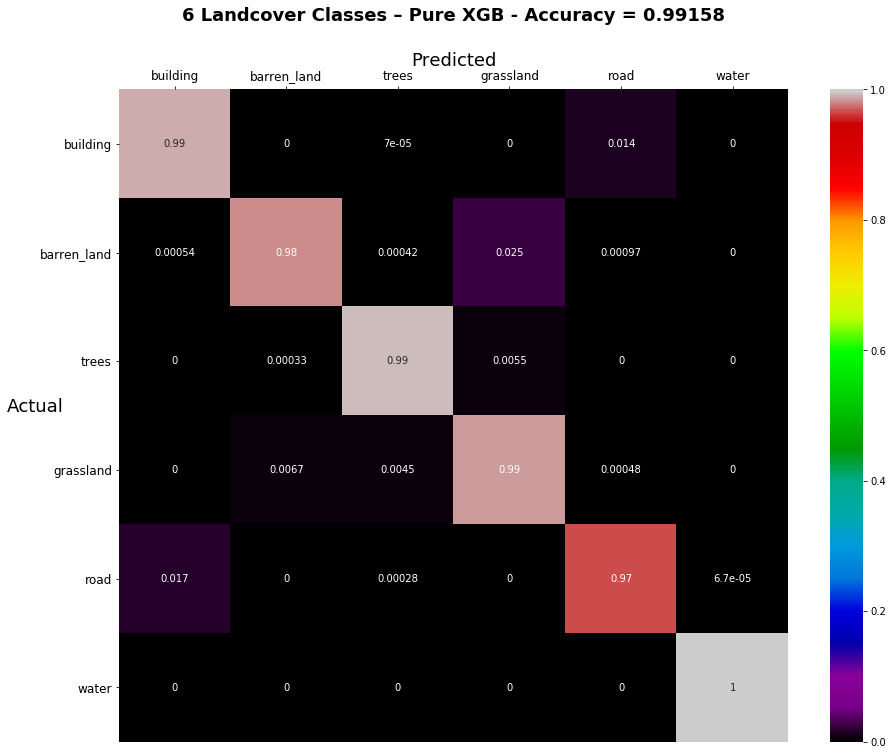

In [49]:
eval_pure_xgb(load_pure_xgb(version=5), x_test, y_test)

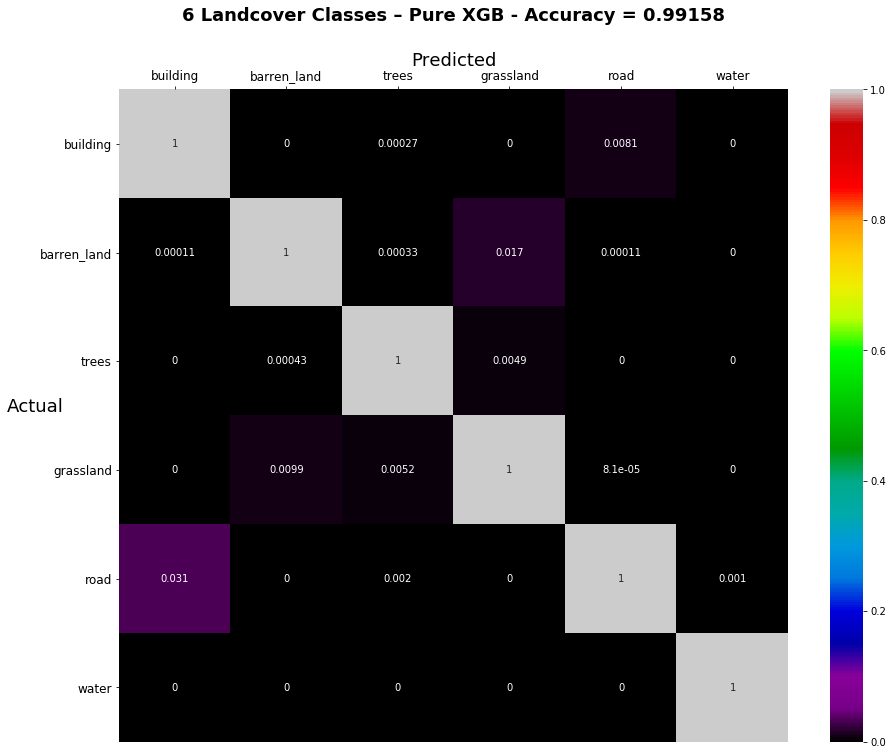

In [22]:
eval_pure_xgb(load_pure_xgb(version=5, param=param), x_test, y_test)

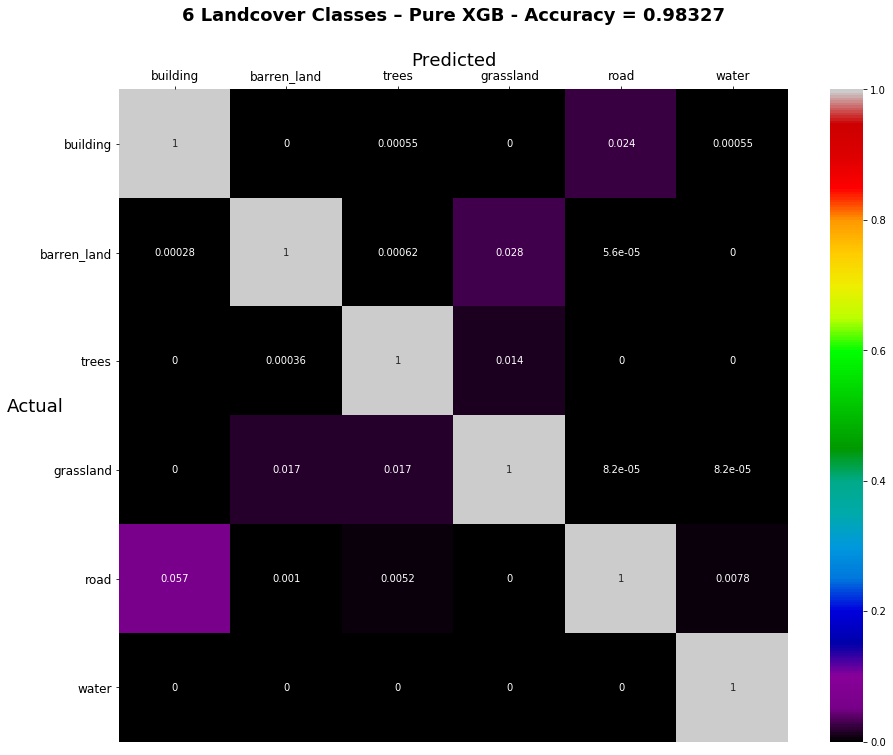

In [74]:
eval_pure_xgb(load_pure_xgb(version=4, param=param), x_test, y_test)

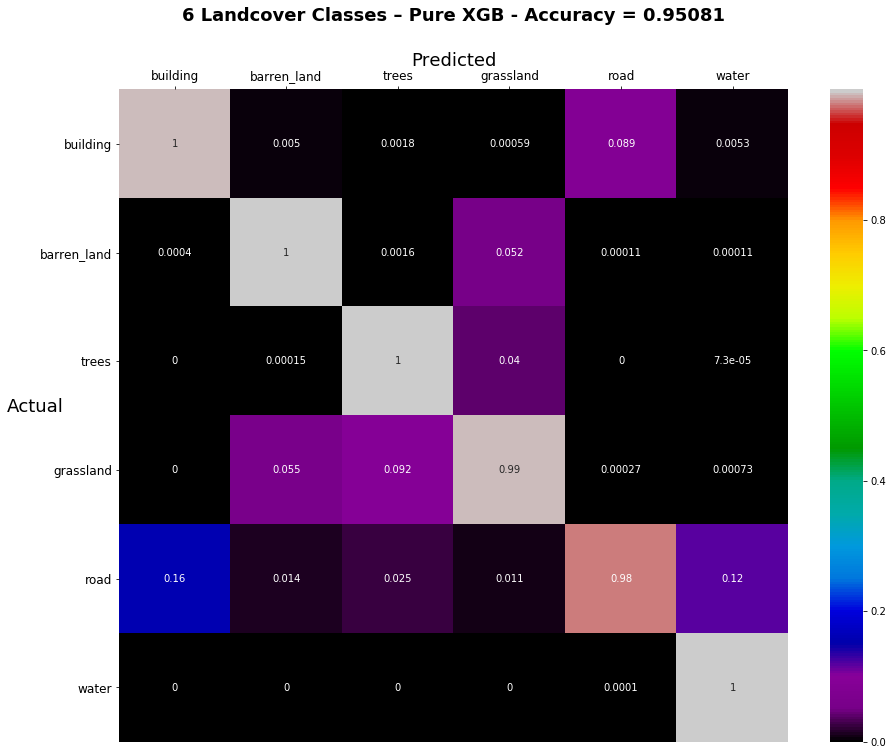

In [75]:
eval_pure_xgb(load_pure_xgb(version=3, param=param), x_test, y_test)

/home/worker3/utils/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


xgb + cnn score = 0.9944691358024691


/home/worker3/utils/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


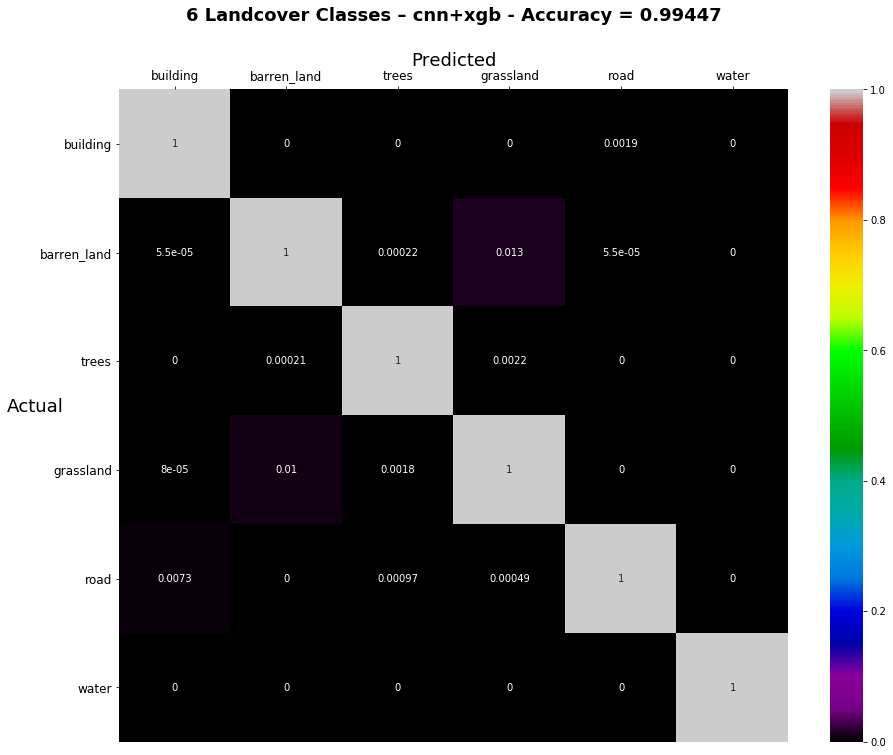

In [76]:
xgb_cnn = load_xgb_cnn()
eval_cnn_xgb(xgb_cnn, x_test_cnn, y_test)

In [19]:
train_xgboost_cnn(x_train_cnn, y_train, version=5)

feature layer out complete
feature layer shape is: (324000, 100)
feature layer type is: <class 'numpy.ndarray'>
<class 'numpy.float32'>
Training complete. Model saved and memory cleared.
Load model to evaluate.


In [ ]:
#xgb_cnn_v5 = load_xgb_cnn(params=param, 6)

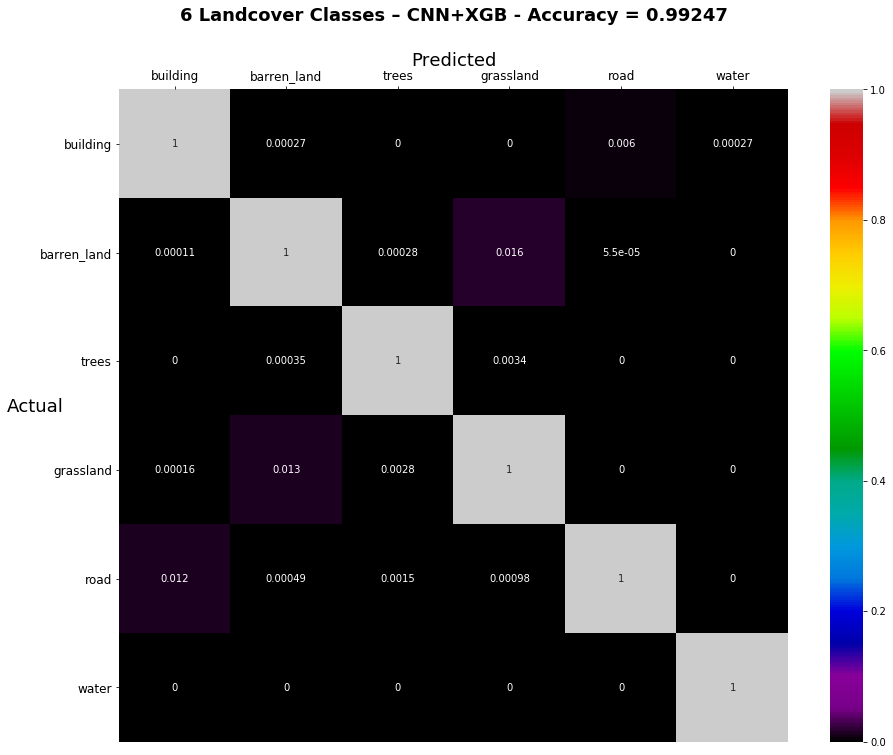

In [17]:
eval_cnn_xgb(load_xgb_cnn(params=param, version=6), x_test_cnn, y_test)

In [ ]:
#num_features = [(5,100),(6,200),(7,300),(8,400),(9,500),(10, 600),(11,700),(12,800),(13,900), (14,None)]

In [35]:
train_xgboost_cnn(x_train_cnn, y_train, version=8, num_round=300, gpu=False)

feature layer out complete
feature layer shape is: (324000, 256)
feature layer type is: <class 'numpy.ndarray'>
<class 'numpy.float32'>
Training complete. Model saved and memory cleared.
Load model to evaluate.


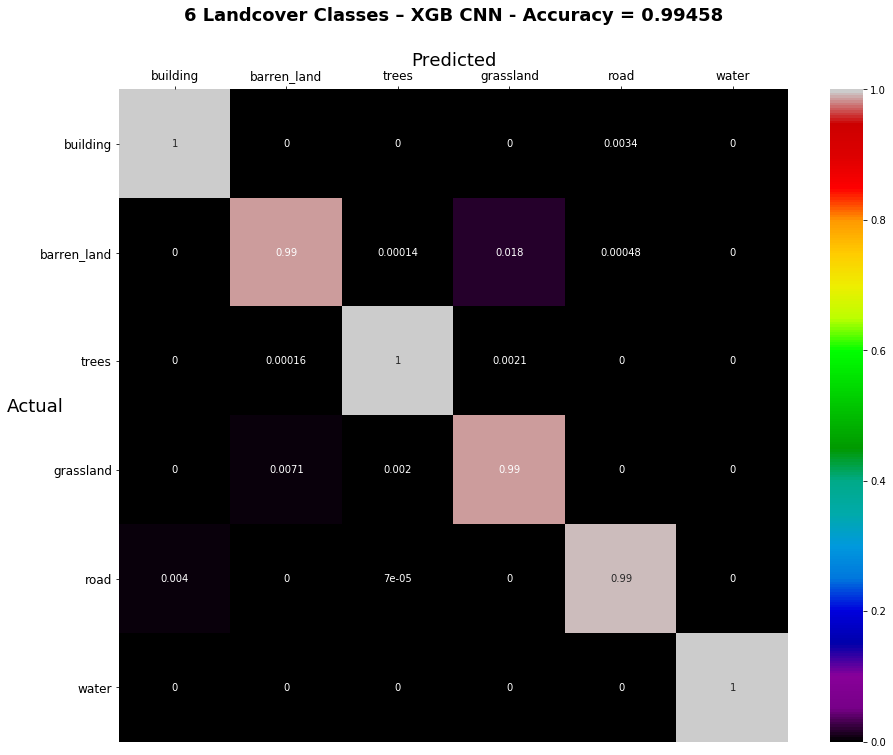

In [53]:
eval_cnn_xgb(load_xgb_cnn(filename='xgb_cnn_100_v6.model'), x_test_cnn, y_test)

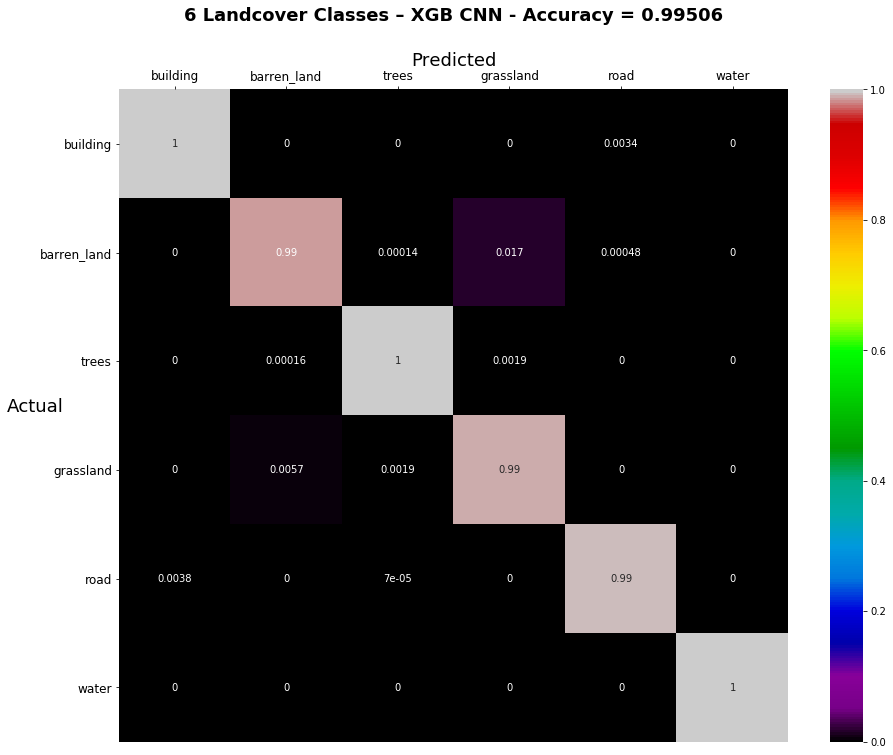

In [52]:
eval_cnn_xgb(load_xgb_cnn(filename='xgb_cnn_200_v7.model'), x_test_cnn, y_test)

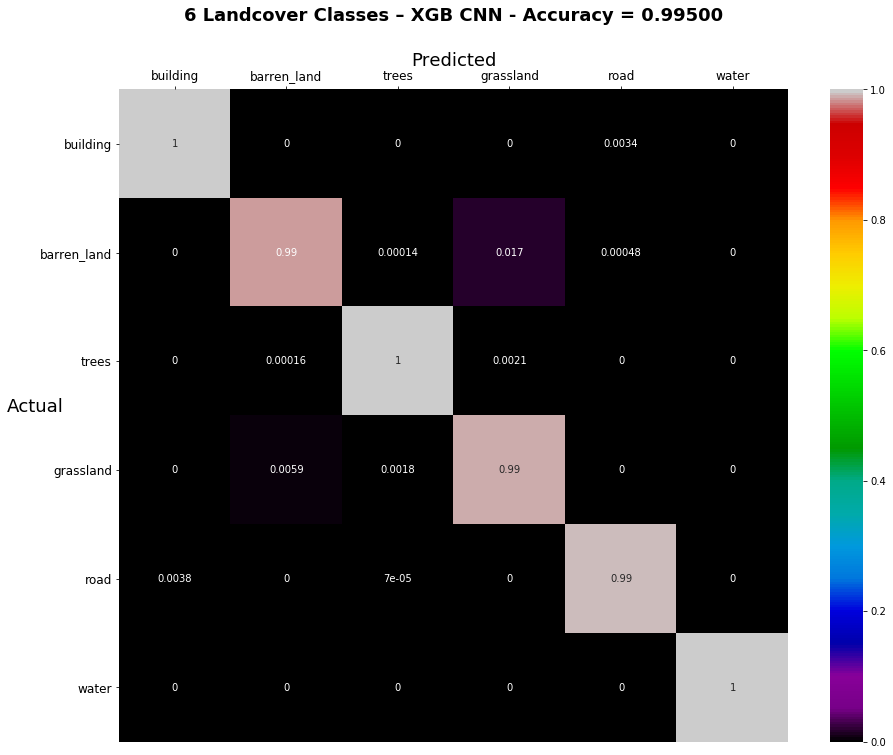

In [54]:
eval_cnn_xgb(load_xgb_cnn(filename='xgb_cnn_300_v8.model'), x_test_cnn, y_test)

In [16]:
pure_model = load_cnn("baseline_model_atom_5.5e-5.h5")

81000/81000 [==============================] - 16s 199us/step
Model accuracy = 0.9936049382716049


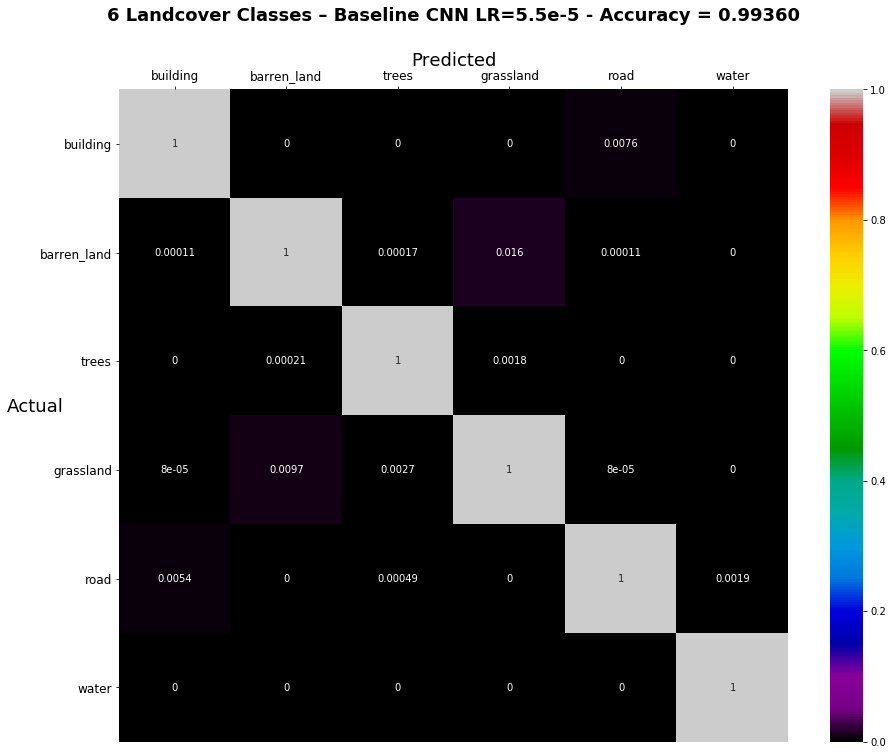

In [18]:
evaluate_cnn(pure_model, "Baseline CNN LR=5.5e-5")

In [50]:
pure_model = load_cnn("baseline_model_atom_5.5e-5.h5")

81000/81000 [==============================] - 14s 177us/step
Model accuracy = 0.9936049382716049


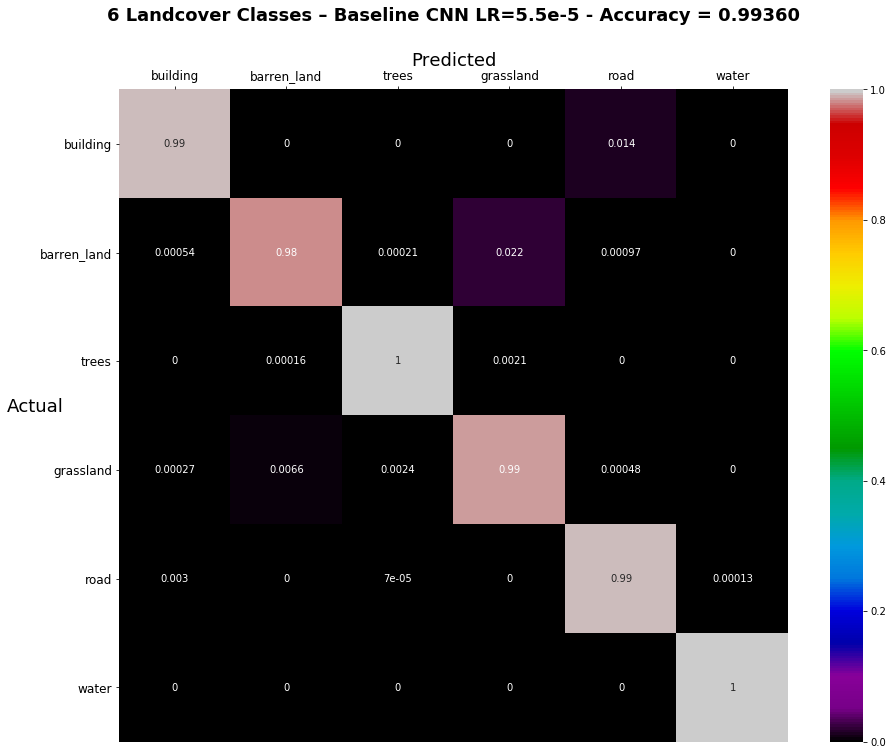

In [51]:
evaluate_cnn(pure_model, "Baseline CNN LR=5.5e-5")

In [ ]:
# continue work here ^

In [16]:
train_pure_xgb(x_train, y_train, version=6, num_round=100)

Training complete. Model saved and memory cleared.
Load model to evaluate.


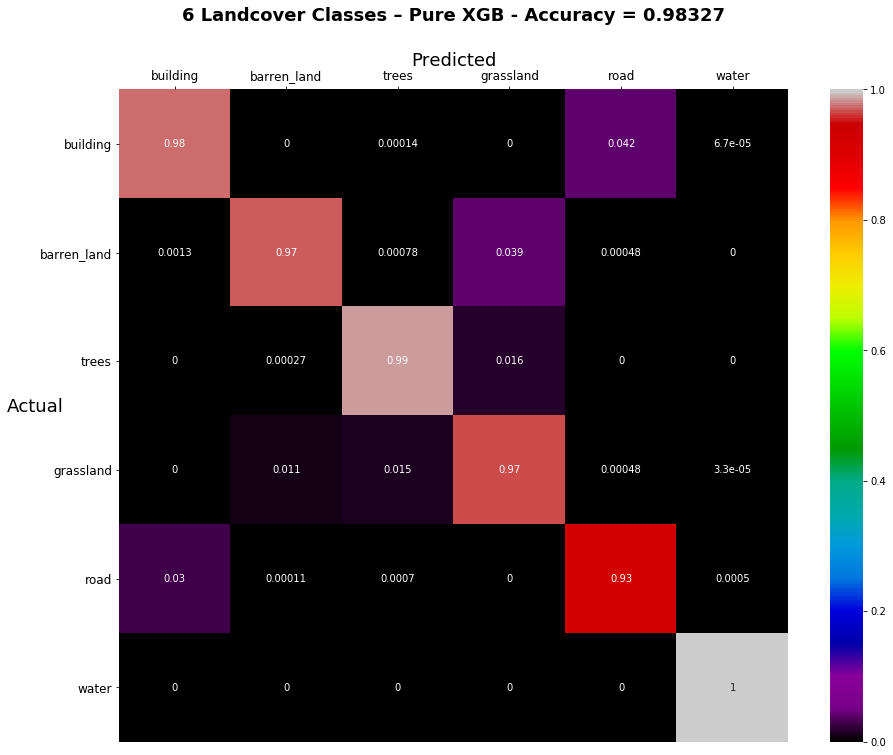

In [47]:
eval_pure_xgb(load_pure_xgb(version=6), x_test, y_test)

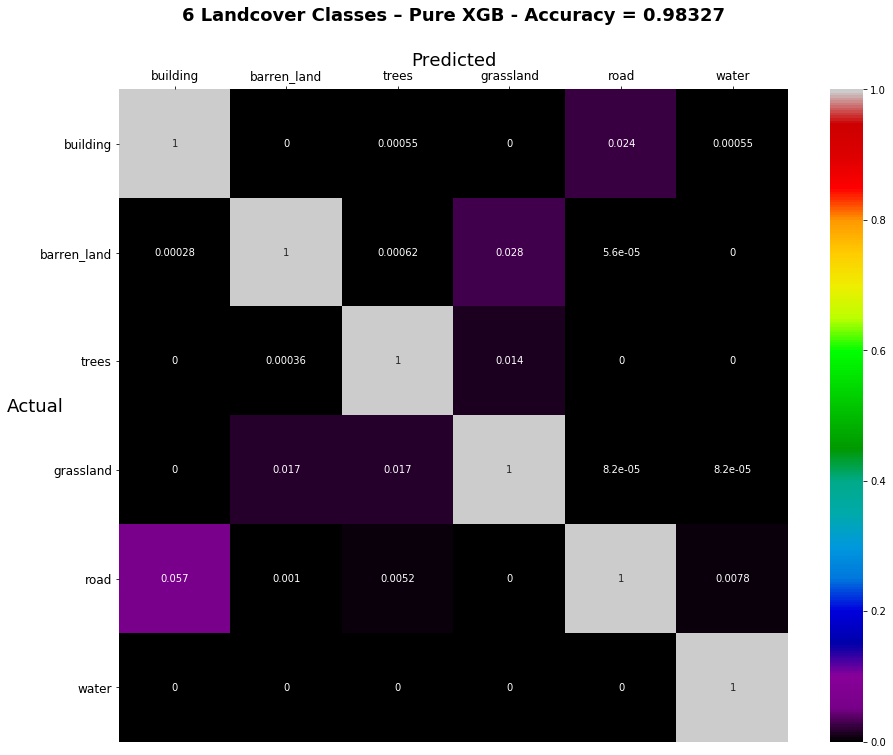

In [18]:
eval_pure_xgb(load_pure_xgb(version=6), x_test, y_test)

In [ ]:
#### fixed confusion matrices ####

In [35]:
rf_model = train_random_forest('random_forest_v1', x_train, y_train)

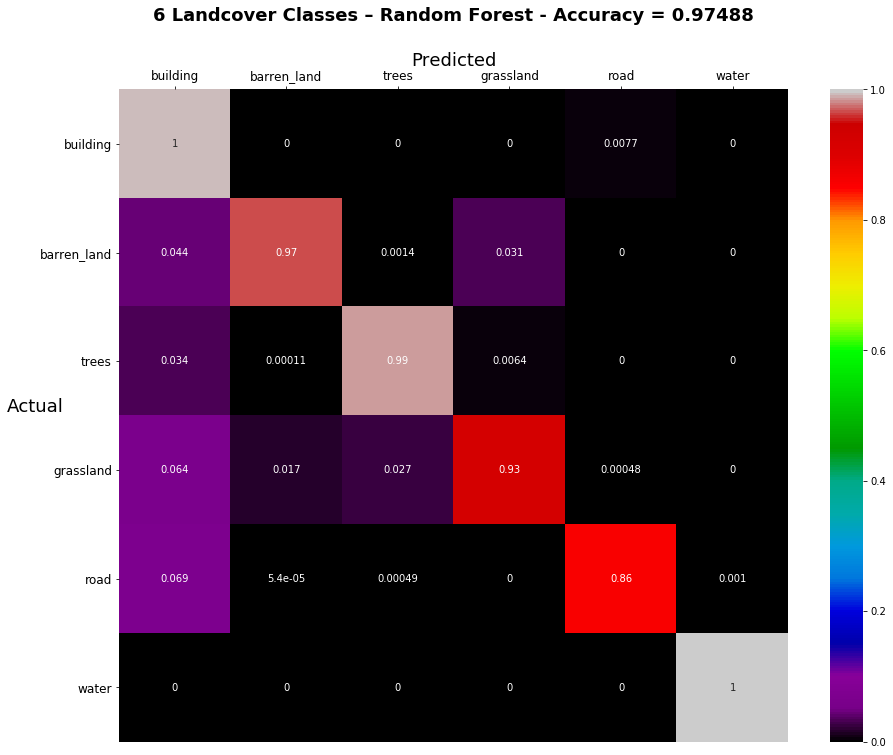

In [46]:
gen_confusion(rf_model.predict(x_test).argmax(axis=1), y_test.idxmax(axis=1).values, sub_title='Random Forest')

In [43]:
(rf_model.predict(x_test).argmax(axis=1) == y_test.idxmax(axis=1)).sum()

78965

In [2]:
# NOTE TO SELF: STILL CAN NOT TRAIN XGBOOST ON FEATURE LAYER W/O MEMORY ERROR
# -- CHECK ALL DATA TYPES
# -- MAKE SURE THERE IS NO SHAPE ISSUE
# -- EXAMINE DETAILS OF FEATURE LAYER DATA (FLOAT VS INT, ETC)
# -- FIGURE OUT DIFFERENCES BETWEEN FEATURE LAYER DATA AND REGULAR IMAGE INPUT DATA

# UPDATE: TRIED ALL OF THESE THINGS. STILL GETTING MEMORY ERROR WHEN TRAINING.
# -- CHECK TO SEE IF I CAN CLEAR THE CNN MODEL FROM MEMORY AFTER FEAT_OUT IS GENERATED

# UPDATE2: PUT CNN MODEL LOAD IN FEAT_OUT SO MODEL IS CLEARED FROM MEMORY WHEN FEAT_OUT NAMESPACE IS EXITED
# -- NO IDEA WHAT COULD BE CAUSING THE MEMORY ISSUE.
# -- TRY TO CREATE FAKE DATA OF SAME TYPE AND DIMENSION AND SEE IF PROBLEM PERSISTS

**notes**

unweighted scores

sdg

[0.048675902403128996, 0.9827654320987654]

atom 1e-5

[0.03177257826200788, 0.9895308641975309]

atom 1e-6

[0.06629317183666403, 0.9753950617283951]

atom 5e-6

[0.04309150624197965, 0.9848888888888889]

atom 5e-5

[0.027689415797445018, 0.9914691358024691]

atom 5e-5 ams

[0.02677221671924655, 0.990358024691358]

atom 7.5e-5

(stuck at .54)

atom 7e-5

(stuck at .54)

atom 6e-5

[0.035970908765554074, 0.9880740740740741]

atom 5.5e-5

[0.019541240541552478, 0.9936049382716049]

atom 5.3e-5

[0.028512682099493404, 0.9908271604938271]

atom 5.7e-5

[0.024852997347159324, 0.9914320987654321]

atom 5.6e-5

(converges at .59)

atom 5.5e-4 v2

[0.02222598712769814, 0.9926296296296296]
